In [63]:
"""This code is designed to build a model that detects credit card fraud within a massive list of transactions. """

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    fbeta_score,
    classification_report,
    make_scorer,
    roc_auc_score
)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xgb






In [64]:
# Load Data
location = r"C:\Users\marck\Kaggle\Fraud_Detection\creditcard.csv"

credit_card_data = pd.read_csv(location)

credit_card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [65]:
# Data description and looking for nulls

nulls = credit_card_data.isnull().sum()

columns_with_nulls = nulls[nulls > 0].index

print(columns_with_nulls)

credit_card_data.describe()


Index([], dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [66]:
#Checking value counts to look for level of imbalance
#This is a very imbalanced dataset, if the categories were closer together and the data was massive, I may downsample
# to even out the classes and reduce processing time
credit_card_data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

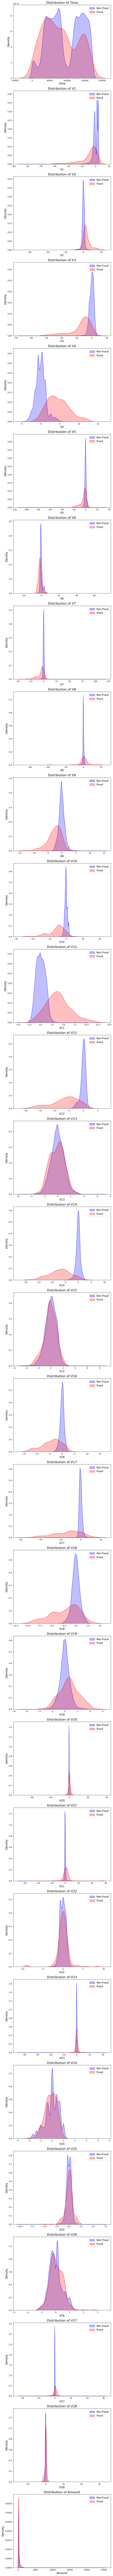

In [67]:
def data_visualization_kde(dataset):
    features = dataset.columns.drop('Class')  
    n_features = len(features)
    
    fig, axes = plt.subplots(n_features, 1, figsize=(8, 6 * n_features))
    
    for i, feature in enumerate(features):
        ax = axes[i] if n_features > 1 else axes  
      
        sns.kdeplot(dataset[dataset['Class'] == 0][feature], ax=ax, color='blue', fill=True, label='Non-Fraud')
        sns.kdeplot(dataset[dataset['Class'] == 1][feature], ax=ax, color='red', fill=True, label='Fraud')
        
        ax.set_title(f'Distribution of {feature}', fontsize=16)
        ax.set_xlabel(feature, fontsize=14)
        ax.set_ylabel('Density', fontsize=14)
        ax.legend(loc='upper right', fontsize=12)
    
    plt.tight_layout()
    plt.show()

data_visualization_kde(credit_card_data)

In [68]:
# Baseline Logistic Regression Model
# Using precision, recall, and F-Beta score instead of Accuracy due to imbalanced dataset

# Define features (X) and target (y)
X = credit_card_data[credit_card_data.columns.difference(['Class'])]
y = credit_card_data["Class"]

#Defining beta as 0.5 because we don't want to flag too many legitimate transactions as fraud as this will drive customers away
beta = 0.5

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Scaling Data to reduce impact of outliers
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

# Fit and predict Log Reg model
lr_model = LogisticRegression()
lr_model.fit(X_scaled_train, y_train)
y_pred = lr_model.predict(X_scaled_test)
y_pred_prob = lr_model.predict_proba(X_scaled_test)[:, 1]

# Calculate precision, recall, and F-beta score metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, beta=beta)
auc = roc_auc_score(y_test,y_pred_prob)

# Print precision, recall, and F-beta score, Classification Report
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Fbeta-score: {fbeta:.2f}')
print(f'AUC: {auc:.2f}')


print('Classification Report:')
print(classification_report(y_test, y_pred))

Precision: 0.88
Recall: 0.61
Fbeta-score: 0.80
AUC: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.88      0.61      0.72       104

    accuracy                           1.00     56962
   macro avg       0.94      0.80      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [69]:
# Get feature importance (coefficients)
coefficients = lr_model.coef_[0]

# Get feature names (columns)
feature_names = X.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute coefficient values to see the most important features
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print the feature importance
print(feature_importance_df[['Feature', 'Coefficient']])

   Feature  Coefficient
24      V4     0.918540
3      V10    -0.763961
7      V14    -0.646805
16     V22     0.500033
6      V13    -0.400243
29      V9    -0.349262
15     V21     0.301286
21     V27    -0.237457
14     V20    -0.230767
28      V8    -0.219673
9      V16    -0.171148
1     Time    -0.146703
5      V12     0.143872
2       V1     0.123832
18     V24     0.107671
25      V5     0.099413
8      V15    -0.090244
26      V6    -0.088156
20     V26     0.088064
4      V11    -0.081391
0   Amount     0.075481
13      V2    -0.071970
22     V28    -0.058287
17     V23    -0.052812
19     V25    -0.044356
27      V7    -0.044288
12     V19     0.038711
10     V17    -0.036227
11     V18     0.023959
23      V3    -0.011407


In [96]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# pipeline to apply scaler and build model
# for big data using Spark, I would include vector assembler as well
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=50, max_depth=7))
])

rf_model = RandomForestClassifier(random_state=42, n_estimators=50, max_depth=7)

# Define scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'fbeta': make_scorer(fbeta_score, beta=beta),
    'roc_auc': 'roc_auc'
}

# Perform 5-fold cross-validation
cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring, return_train_score=True)

# Print the Test results
print("\nTest Results: ")
print(f'Mean Test Precision = {cv_results["test_precision"].mean():.2f}, Std = {cv_results["test_precision"].std():.2f}')
print(f'Mean Test Recall = {cv_results["test_recall"].mean():.2f}, Std = {cv_results["test_recall"].std():.2f}')
print(f'Mean Test F-beta score (beta={beta}): Mean = {cv_results["test_fbeta"].mean():.2f}, Std = {cv_results["test_fbeta"].std():.2f}')
print(f'Mean Test AUC = {cv_results["test_roc_auc"].mean():.2f}, Std = {cv_results["test_roc_auc"].std():.2f}')

#Print the Train Results
print("\nTrain results: ")
print(f'Mean Training Precision: {cv_results["train_precision"].mean():.2f}')
print(f'Mean Training Recall: {cv_results["train_recall"].mean():.2f}')
print(f'Mean Training F-beta score (beta={beta}): {cv_results["train_fbeta"].mean():.2f}')
print(f'Mean Training AUC score: {cv_results["train_roc_auc"].mean():.2f}')


Mean Test Precision = 0.76, Std = 0.38
Mean Test Recall = 0.77, Std = 0.12
Mean Test F-beta score (beta=0.5): Mean = 0.71, Std = 0.36
Mean Test AUC = 0.96, Std = 0.02
Mean Training Precision: 0.99
Mean Training Recall: 0.80
Mean Training F-beta score (beta=0.5): 0.94
Mean Training AUC score: 0.98


In [92]:
# XGBoost with Grid Search

# Parameters I am searching through
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1]}

# Metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'fbeta': make_scorer(fbeta_score, beta=beta),
    'auc': make_scorer(roc_auc_score, needs_proba=True)

}

# Model Pipeline
xgb_model = xgb.XGBClassifier(random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('classifier', xgb_model)      
])

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=5, refit='fbeta', return_train_score=True)

grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:")
print(grid_search.best_params_)

# Best model from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Print metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
auc = roc_auc_score(y_test, y_pred)

print("\nTesting Scores:")
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F-beta score (beta={beta}): {fbeta:.2f}')
print(f'auc score: {auc:.2f}')

# Find index of best parameters
best_index = grid_search.cv_results_['params'].index(grid_search.best_params_)

# Print training scores for the best model
cv_results = grid_search.cv_results_

print("\nTraining Scores for the Best Model:")
print(f"Mean Training Precision: {cv_results['mean_train_precision'][best_index]:.2f}")
print(f"Mean Training Recall: {cv_results['mean_train_recall'][best_index]:.2f}")
print(f"Mean Training F-beta score (beta=0.5): {cv_results['mean_train_fbeta'][best_index]:.2f}")
print(f"Mean Training AUC score: {cv_results['mean_train_auc'][best_index]:.2f}")

C:\Users\marck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  raise ValueError(
C:\Users\marck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\marck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:15

Best parameters found:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

Testing Scores:
Precision: 0.97
Recall: 0.82
F-beta score (beta=0.5): 0.93
auc score: 0.91

Training Scores for the Best Model:
Mean Training Precision: 1.00
Mean Training Recall: 1.00
Mean Training F-beta score (beta=0.5): 1.00
Mean Training AUC score: 1.00


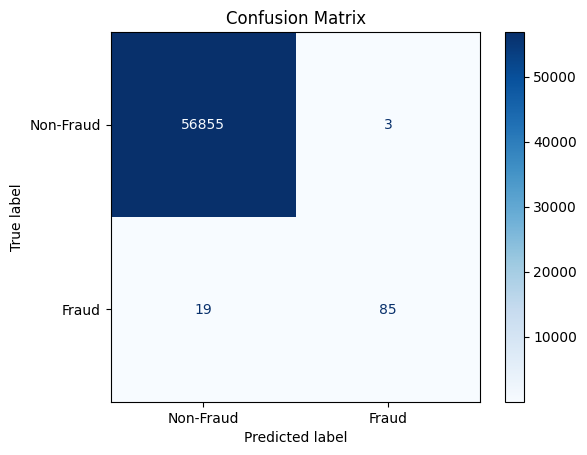

In [93]:
# Confusion Matrix to see what XGBoost model mislabelled

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Precision: 0.98
Recall: 0.77
F-beta score (beta=0.5): 0.93
AUC score: 0.99


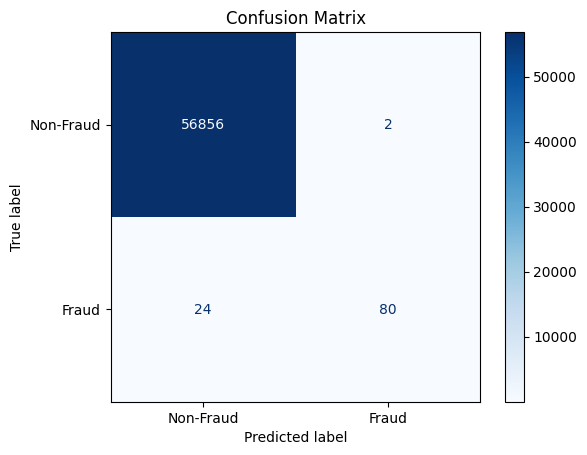

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_models = [
    ('logistic', lr_model),
    ('random_forest', rf_model),
    ('xgboost', best_xgb_model)
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression()  # Final estimator or meta-model
)

# Train the stacking ensemble model
stacking_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = stacking_model.predict(X_test_scaled)
y_pred_prob = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
auc = roc_auc_score(y_test, y_pred_prob)

# Print metrics
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F-beta score (beta=0.5): {fbeta:.2f}')
print(f'AUC score: {auc:.2f}')


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraud', 'Fraud'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Precision: 0.95
Recall: 0.77
F-beta score (beta=0.5): 0.91
AUC score: 0.99


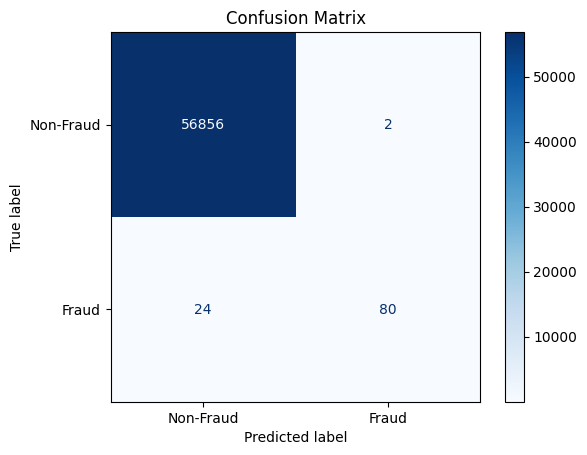

In [98]:
#Voting model because XGBoost and Random Forest are prone to overfitting

voting_model = VotingClassifier(
    estimators=[
        ('logistic', lr_model),
        ('random_forest', rf_model),
        ('xgboost', best_xgb_model)
    ],
    voting='soft'
)

# Train the stacking ensemble model
voting_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = voting_model.predict(X_test_scaled)
y_pred_prob = voting_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
auc = roc_auc_score(y_test, y_pred_prob)

# Print metrics
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F-beta score (beta=0.5): {fbeta:.2f}')
print(f'AUC score: {auc:.2f}')

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()